In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance#
from pyproj import Proj,transform
import seaborn as sns
import copy
from multiprocessing import Pool
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy", towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")
#Calculate Euclidean distances using H

# Below, can be run once you have made 'All_data'

In [2]:
Data=pd.read_csv("all_farms/All_data",sep = '\t', header = 0)

In [3]:
Copy1 = pd.read_csv('all_farms/All_data', sep = '\t', header = 0)

In [4]:
copy2 = Copy1.values
true_cattle =  copy.deepcopy(copy2[:,3])
true_sheep =  copy.deepcopy(copy2[:,13])
cattle = copy2[:,3]
sheep = copy2[:,13]

In [5]:
xcoord = Data['xcoord'].values
ycoord = Data['ycoord'].values

In [6]:
joinedinput = np.column_stack((xcoord, ycoord))

In [2]:
# N = len(Data)
# N
(13*50)/60

10.833333333333334

In [8]:
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')
dist = dist/100000

In [9]:
equipment_list = Data['equipment'].values
shares_water_list = Data['water'].values
shares_grazing_list = Data['grazing'].values
shares_milk_list = Data['milk'].values
shares_vet_list = Data['vet'].values
contact_animal_list = Data['contact_animal'].values
contact_human_list = Data['contact_people'].values

In [10]:
# tr = np.random.negative_binomial(1, 1/2, N) #Draw immune periods (1 day)
tr = 2*np.ones(N)
print(np.mean(tr))
        
psi = 0.00657
# psi = 2.5
nu = 1.99*(10**(-4.8))
xi = 4.65
zeta = 2.80
chi = 0.403
phi = 0.799
rho = 0.000863


epsilon = np.zeros(N)
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods (5 days)
r = np.random.negative_binomial(30, 30/38, N) #Draw infectious periods (8 days)
# r = np.random.negative_binomial(8, 8/16, N)
sum(r==0)


2.0


4

In [11]:
np.max(dist)

1.3401452351517724

In [12]:
# kerneldist =(10e4*psi)/((10e2*psi)**2 + dist**2)   # This is without a cap
kerneldist = (psi)/(psi**2 + dist**2)
# kerneldist = np.zeros(shape=(N,N))
# for i in range(len(dist)):
#     for j in range(len(dist)):
#         if dist[i,j] <= 60:
#             kerneldist[i,j] = (psi)/((psi)**2 + dist[i,j]**2)

In [13]:
# This takes quite a while to run, sit back and have a cuppa
# once this has run, you won't need to run it again unless your kernel restarts

shares_equipment = np.zeros(shape = (N,N)) #cap at 10km
shares_water = np.zeros(shape = (N,N)) #cap at 10km
shares_grazing = np.zeros(shape=(N,N)) #cap at 10km
shares_milk = np.zeros(shape = (N,N)) #cap at 10km
shares_vet = np.zeros(shape = (N,N)) #cap at 10km
contactanimal = np.zeros(shape = (N,N))
contacthuman = np.zeros(shape = (N,N)) 

for i in range(N):
    for j in range(N):
        if i != j:
            if dist[i,j] <= 10/100:
                if (shares_milk_list[i]==1 and shares_milk_list[j] ==1):
                    shares_milk[i,j] = 1
                if (shares_water_list[i]==1 and shares_water_list[j] ==1):
                    shares_water[i,j] =1
                if (shares_grazing_list[i] ==1 and shares_grazing_list[j] ==1):
                    shares_grazing[i,j] =1
                if (equipment_list[i]==1 and equipment_list[j] ==1):
                    shares_equipment[i,j] =1
                if (shares_vet_list[i]==1 and shares_vet_list[j] ==1):
                    shares_vet[i,j] = 1
            if dist[i,j] <= 60/100:
                if (contact_animal_list[i]==1 and contact_animal_list[j] ==1):
                    contactanimal[i,j] = 1
                if (contact_human_list[i]==1 and contact_human_list[j] ==1):
                    contacthuman[i,j] = 1

In [14]:
q = np.random.negative_binomial(2*28, 2*28/(4*28), N) #Draw immune periods (2 months)
np.mean(q)


56.00279467368075

In [15]:
# [a1, a2, a3,a4,a5,a6,a7] = [0.16964086, 0.16230848, 0.1756672,  0.06334324, 0.13775076, 0.13500596,0.15628351]
[a1, a2, a3,a4,a5,a6,a7] = (1/7)*np.ones(7)

transmission_matrix = (
a1*shares_equipment+
 a2*shares_water+
 a3*shares_grazing + 
 a4*shares_milk + 
 a5*shares_vet + 
 a6*contactanimal + 
 a7*contacthuman)

In [16]:
T = copy.deepcopy(transmission_matrix)

In [17]:
transmission_matrix[5,6]
T[5,6]

0.14285714285714285

In [18]:
farm_cost = np.zeros(N)
for i in range(0,N):
    farm_cost[i] = 150*sheep[i] + 150*cattle[i]

Data['cost'] = farm_cost

In [19]:
kerneldist[50,200]

0.02915958717086779

# Below is the main code.
- A[:,0] - index of farm (only added into the code when farm is infected or if its vaccinated)
- A[:,1] - time a farm is infected
- A[:,2] = s - length of time/period a farm is exposed for  (4 days)
- A[:,3]  =r - length of time/period a farm is infectious for (8 days)
- A[:,4] = tr - length of time/period a farm is waiting before triggering vaccines (1 day) - maybe we should delete this completely
- A[:,5] = q - length of time/period a farm is naturally immue for (2 months) 
- A[:,6] = end_q - time at which a farm becomes susceptible again
- A[:,7] = t_vac - time at which a farm is vaccinated
- A[:,8]=v - length of time/period a farm is immune for, induced from vaccines (6 months)
- A[:,9] =end_v - time at which vaccine immunity ends

In [20]:
eff = 0.3
ring_vac = 3
T = copy.deepcopy(transmission_matrix)
tmax = 600
results = np.zeros((8,tmax))
print(results.shape)

(8, 600)


In [21]:
def kenyaFMD(input1):
    for i in range(1):
        start_time = time.time()

        cattle = copy.deepcopy(Data['cattle'].values).astype(int)
        sheep = copy.deepcopy(Data['sr'].values).astype(int)
        t = 0
        cost = np.zeros(N)
        A = np.zeros(shape=(N,10))     
        A[:,0] = -1 
        vac = np.zeros(N)
        cumInf = np.zeros(tmax)
        numInf = np.zeros(tmax)

        initial1 = random.randint(0,N-1)
        initial2 = (initial1+1)%N
        initial3 = (initial2+1)%N

        infect_cow = np.zeros(N)
        infect_sheep = np.zeros(N)
        I = np.zeros(N)

        I[initial1] = 1
        I[initial2] = 1
        I[initial3] = 1

        A[initial1, ] = [initial1, 0, s[initial1], r[initial1], tr[initial1], q[initial1], 0,0,  0,0]
        A[initial2, ] = [initial2, 0, s[initial2], r[initial2], tr[initial2], q[initial2], 0,0, 0,0]
        A[initial3, ] = [initial3, 0, s[initial3], r[initial3], tr[initial3], q[initial1], 0,0, 0,0]

        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i] ==0]
        exposedind = [i for i in range(np.size(I)) if I[i] == 1]
        immuneind = [i for i in range(np.size(I)) if I[i] ==4]
        vaccineind = [i for i in range(np.size(I)) if I[i]==3]

        Inf=[len(infectind)]
        Sus = [len(susceptind)]
        Exp = [len(exposedind)]
        Imm = [len(immuneind)]
        Vac = [len(vaccineind)]

        time_plot=[0]
        %matplotlib notebook
        start_time = time.time()
    #         fig = plt.figure(figsize = (10,4))
    #         ax = fig.add_subplot(121)
    #         ax1 = fig.add_subplot(122)
    #         plt.ion

    #         fig.show()
    #         fig.canvas.draw()
        Dose = []
        VAC = []
        travelled = []
        Capacity = 80
        Coverage = 0.25

        while t<tmax:
            infNum = 0
            t = t+1
            
            if t >(tmax/2):
                Capacity = 160
#                 Coverage = 1
#                 eff = np.random.beta(8,2)
            else:
                Capacity = 80
#                 Coverage = 0.25
#                 eff = np.random.beta(2,8)
#             print(t)

            ################################### WITHIN FARM INFECTION ####################################
            for farm in infectind:
                Num_livestock = infect_cow[farm] + infect_sheep[farm]
                λ = 0.1
                inf1 = 1-((1-λ)**Num_livestock) 
                for animals in range(int(cattle[farm]+sheep[farm])):
                    p_beta = np.random.uniform(0,1)
                    if (p_beta<inf1) and Num_livestock<=(sheep[farm]+cattle[farm]):
                        if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                            infect_sheep[farm] += 1
                        elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                            infect_cow[farm] +=1

            ################################# BETWEEN FARM INFECTION  #####################################

            ###############################################################################################
            ######################################### ATTRIBUTES ##########################################
        #         ###############################################################################################
        #         transmission_matrix = (a1*shares_equipment+ #need to clear and update this everytime
        #         a2*shares_water+
        #         a3*shares_grazing + 
        #         a4*shares_milk + 
        #         a5*shares_vet + 
        #         a6*contactanimal + 
        #         a7*contacthuman)
    #             attribute_matrix = copy.deepcopy(transmission_matrix)
        #         print(attribute_matrix[6,5], transmission_matrix[6,5])

            beta = np.zeros(N)
            beta1 = nu*(xi*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi)
            beta3 = zeta*(infect_cow)**chi + infect_sheep**chi

            attribute_matrix = transmission_matrix * beta3
            c = np.einsum('ij,ji->i', attribute_matrix[:,I==2], kerneldist[I==2,:])
            beta = beta1*c

            prob_inf = (1 - np.exp(-beta))
            unif = np.random.uniform(0, 1, N)
            ### immunity ###
            cattle[I ==4] = 0
            cattle[I ==3] = 0
            sheep[I==4] = 0
            sheep[I==3] = 0
            prob_inf[I==3] = 0
            prob_inf[I==4] = 0
            

            for i in range(0,N):

                if (unif[i] <= prob_inf[i] and I[i] == 0):
                    cattle[i] = true_cattle[i]
                    sheep[i] = true_sheep[i]
                    I[i] =  1
                    A[i, ] = [i, t, s[i], r[i], tr[i], q[i], 0, 0,0,0]

            #########################################################################################################
            ######################################## UPDATE STATES ##################################################
            #########################################################################################################

            ###################################### EXPOSED TO INFECTIOUS ############################################

            inf = A[:,0][A[:,1] + A[:,2] == t]

            I[inf.astype(np.int64)] = 2


            ####################### UPDATE NUMBER OF INFECTED ANIMALS WITHIN AN INFECTIOUS FARM #####################

            for i in inf: 
                i = int(i)
                if (random.random() < (sheep[i]/(sheep[i] +cattle[i])) and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                    infect_sheep[i] += 1
                elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                    infect_cow[i] +=1


        ########################################### 25% RING VACCINATION ###########################################
        #         eff = efficac
            trig = A[:,0][A[:,1] + A[:,2] + A[:,4] == t] #trigger vaccines
            RingVac = 1.0*(ring_vac/100)
            lenI = len(I)
            for i in range(len(trig)):
                trigi = trig[i].astype(np.int64)
                n2 = [k for k in range(lenI) if dist[trigi, k] <RingVac]
                index=list(np.where(np.random.uniform(0,1,len(n2))<Coverage*np.ones(len(n2)))[0])
                n=list(np.asarray(n2)[index])

                for j in range(len(n)):
                    m = n[j]
                    if A[m,7] == 0:
                        VAC = np.append(VAC, m)
                        travelled.append(dist[trig[i].astype(np.int64), m])
            VAC, indices = np.unique(np.array(VAC, dtype=np.int), return_inverse=True)
            VAC = VAC[indices]
            if len(VAC) > 0:
                VAC = VAC.astype(np.int64)
            if len(VAC)>Capacity:
                cost[VAC[0:Capacity]] += farm_cost[VAC[0:Capacity]]

                for j in range(len(VAC[0:Capacity])):
                    m = VAC[j]
                    A[m,0] = m
                    A[m,7] = t
                    if (I[m] == 0):

                        if np.random.uniform(0,1) <eff:
                            A[m, 8] = np.random.negative_binomial(6*28, 6*28/(12*28))
                            A[m,9] = A[m,8] + t
                            I[m] = 3
                            cattle[m] = 0
                            sheep[m] = 0
                    elif (I[m] == 3):
                        if np.random.uniform(0,1) < eff:
                            immunity = np.random.negative_binomial(6*28, 6*28/(12*28))

                            if (A[m,9]) < (immunity+t):
                                A[m,8] = immunity
                                A[m, 9] = immunity +t
                            else:
                                A[m,8] = A[m,9] - t
                    elif (I[m] ==4):
                        if np.random.uniform(0,1) < eff:
                            immunity = np.random.negative_binomial(6*28, 6*28/(12*28))
                            if (A[m,6] )< (immunity +t):
                                A[m,8] = immunity
                                A[m,9] = immunity + t
                                I[m] = 3
                                A[m,6] = 0
                                cattle[m] = 0
                                sheep[m] = 0
                VAC = np.delete(VAC, range(0, Capacity), None)
            else: 
                cost[0:len(VAC)] += farm_cost[0:len(VAC)]

                for j in range(len(VAC)):
                    m = VAC[j]
                    A[m, 0] = m
                    A[m, 7] = t
                    if (I[m] == 0):
                        if np.random.uniform(0,1) <eff:
                            A[m, 8] = np.random.negative_binomial(6*28, 6*28/(12*28))
                            A[m, 9] = A[m, 8] +t
                            I[m] = 3
                            cattle[m] = 0
                            sheep[m] = 0
                    elif (I[m] == 3):
                        if np.random.uniform(0,1) < eff:
                            immunity = np.random.negative_binomial(6*28, 6*28/(12*28))
                            if (A[m,9]) < (immunity +t):
                                A[m,8] = immunity
                                A[m,9] = immunity +t
                            else:
                                A[m,8] = A[m,9] - t
                    elif (I[m] ==4):
                        if np.random.uniform(0,1) < eff:
                            immunity = np.random.negative_binomial(6*28, 6*28/(12*28))
                            if (A[m,6] )< (immunity +t):
                                A[m,8] = immunity
                                A[m,9] = immunity + t
                                I[m] = 3
                                A[m,6] = 0  
                                cattle[m] = 0
                                sheep[m] = 0
                VAC = np.delete(VAC, range(0, len(VAC)), None)


            ########################################### vaccine wears off ###########################################

            new_dose = A[:,0][A[:,7]+6*28 == t] #records when the farmer will get a new vaccine


            for j in new_dose:
                j = j.astype(np.int64)
                if (A[j,8] > 6*28) and (I[j]==3):
                    A[j, 7] = 0
                else: 
                    A[j, 7] = 0
                    A[j, 8] = 0
                    A[j,9] = 0
                    if I[j] == 3:
                        I[j] = 0
                        cattle[j] = true_cattle[j]
                        sheep[j] = true_sheep[j]

            vaccinate_ends = A[:,0][A[:,9] == t]

            for j in vaccinate_ends:
                j = j.astype(np.int64)
                if I[j] ==3:
                    I[j] =0
                    cattle[j] = true_cattle[j]
                    sheep[j] = true_sheep[j]

            ######################################### IMMUNITY #######################################################

            rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to IM state once infectious period is over
            for i in rem:
                i = i.astype(np.int64)
                if I[i] == 2:
                    I[i] =4
                    cattle[i] = 0
                    sheep[i] = 0
                    A[i, 6] = A[i, 5] +t
                    infect_sheep[i] = 0
                    infect_cow[i] = 0

            immune = A[:,0][A[:,1] + A[:,2] + A[:,3] + A[:,5] == t] #Move to S state once immune period is over
            I[immune.astype(np.int64)] = 0
            A[immune.astype(np.int64), ] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            for k in immune:
                k = k.astype(np.int64)
                cattle[k] = true_cattle[k]
                sheep[k] = true_sheep[k]


            #### WITHIN FARM RECOVERY ####
            infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
            for farm in infected:
                mu = 0.01
                for animals in range(int(Num_livestock)):
                    recover = np.random.uniform(0,1)

                    if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                        if (random.random() <(infect_sheep[farm]/(infect_sheep[farm]+infect_cow[farm])) and infect_sheep[farm]>=1 ):
                            infect_sheep[farm] -= 1
                        elif infect_cow[farm]>=1: 
                            infect_cow[farm] -=1
                        if infect_sheep[farm]+infect_cow[farm] ==0: 
                            I[farm] = 4
                            infect_sheep[farm] = 0
                            infect_cow[farm] = 0
                            cattle[farm] = 0
                            sheep[farm] = 0
                            A[farm, 6] = A[farm, 5] +t

            ############################################### PLOTS #####################################################

            infectind = [i for i in range(np.size(I)) if I[i]==2]
            susceptind = [i for i in range(np.size(I)) if I[i]==0]
            exposedind = [i for i in range(np.size(I)) if I[i] == 1]
            immuneind = [i for i in range(np.size(I)) if I[i] ==4]
            vaccineind = [i for i in range(np.size(I)) if I[i]==3]
            had_dose = [i for i in range(np.size(I)) if A[i,6]>0]
            if t>0:
                infNum += len(inf)

            numinf2 = len(inf)
            Dose.append(len(had_dose))
            Inf.append(len(infectind))
            Sus.append(len(susceptind))
            Exp.append(len(exposedind))
            Imm.append(len(immuneind))
            Vac.append(len(vaccineind))
            time_plot.append(t)



            xinfectplot = xcoord[infectind]
            yinfectplot = ycoord[infectind]
            xsusceptplot = xcoord[susceptind]
            ysusceptplot = ycoord[susceptind]
            xexposeplot = xcoord[exposedind]
            yexposeplot = ycoord[exposedind]
            ximmuneplot = xcoord[immuneind]
            yimmuneplot = ycoord[immuneind]
            xvaccineplot = xcoord[vaccineind]
            yvaccineplot = ycoord[vaccineind]
    #             ax.clear()

    #             ax1.clear()


        #         ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
    #             ax1.plot(time_plot,Inf,label='Infectious', c='r')
        #         ax1.plot(time_plot, Imm, label = 'immune', c='b')
        #         ax1.plot(time_plot, Vac, label = 'vaccine', c='g')
    #             plt.xlabel('time')
    #             plt.ylabel('Number of Farms')


    #             ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
    #             ax.set_xticks([])
    #             ax.set_yticks([])
    #             ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
    #             ax.scatter(ximmuneplot, yimmuneplot, c='b', marker='o', s=6, label='Immune')
    #             ax.scatter(xvaccineplot, yvaccineplot, c='g', marker = 'o', s = 6, label = 'vaccine')
    #             ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])


    #             plt.title('Day {}, Infected: {}, Vaccine functional: {}'.format(t, np.size(xinfectplot), np.size(xvaccineplot)),fontsize = 12)
    #             ax.axis('scaled')
    #             ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

            cumInf[t] = cumInf[t-1] + infNum

            numInf[t] = numinf2

            if sum(I == 1) + sum(I == 2) == 0:
                a = cumInf[t-1]
                cumInf[t:] = a
                numInf[t:] = 0
                endemic = 0
                total_numinf = cumInf[-1]
                break
            if t == (tmax-1):
                endemic = np.mean(Inf[(tmax-100):])
                total_numinf = cumInf[-1]
                break

            
    return time_plot, Inf, cumInf, numInf, total_numinf, endemic, results



In [22]:
# %reload_ext line_profiler
# %lprun -f kenyaFMD tp, inf, cuminf, numinf, totalinf, endemic = kenyaFMD()


In [ ]:
data = range(50)
num_threads=8
with Pool(num_threads) as pool:
    start=time.time()
    results2 = pool.map(kenyaFMD, data)
    end=time.time()

In [ ]:
realisations = 50
Infections = np.zeros(shape = (realisations, tmax))
TotalInfections = np.zeros(realisations)
EndemicLevel = np.zeros(realisations)
for i in range(realisations):
    if len(results2[i][1]) < tmax:
        Infections[i,:] = np.concatenate((results2[i][1], np.zeros(600-len(results2[i][1]))))
    else:
        Infections[i,:] = results2[i][1]
    TotalInfections[i] = results2[i][4]
    EndemicLevel[i] = results2[i][5]

In [ ]:
plt.plot(range(tmax), np.mean(Infections, axis = 0))

In [ ]:
np.save('Infections_Capacity', Infections)
np.save('Endemic_Capacity', EndemicLevel)
np.save('Size_Capacity', TotalInfections)

In [ ]:
np.mean(EndemicLevel)

In [ ]:
lengths = np.arange(0,105, 15)
for k in lengths:
    

In [22]:
infection = np.load('Infections_All_attributes.npy')

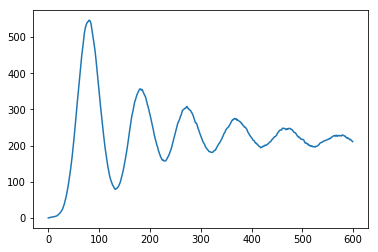

In [24]:
plt.plot(range(tmax), np.mean(infection, axis = 0))

In [26]:
endemic = np.load('Endemic_All_attributes.npy')

In [27]:
np.mean(endemic)

214.36419999999998